In [54]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.model_selection import train_test_split
from plotting import set_defaults
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "bld"

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [5]:
# -- load comparison set from bld
print("getting {0} spectra...".format(comp))
#try:
#    blds_left = np.load("../../../gdobler_output/output/blds_left.npy")
#except:
blds = np.array([np.load(i) for i in
                sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                .format(comp)))])
blds = blds[good]
# np.save("../../../gdobler_output/output/blds_left.npy",blds)

getting bld spectra...


In [6]:
def normalize_spectra(specs):
    ms, bs = [], []
    for ii in range(specs.shape[0]):
        m = specs[0].mean()/specs[ii].mean()
        b = 0.0
        ms.append(m)
        bs.append(b)
        
    ms   = np.array(ms)
    bs   = np.array(bs)
    norm = specs*ms[:,np.newaxis] + bs[:,np.newaxis]
    rat  = norm/norm[0]
    return rat

In [7]:
# -- normalize spectra

vrat = normalize_spectra(vegs)
brat = normalize_spectra(blds)

In [8]:
print(vrat.shape, brat.shape)

(1102, 848) (1102, 848)


In [9]:
# -- take the ratio of ratios
D_vrat = vrat/brat   # vegetation to buildings
print(D_vrat.shape)

# -- normalize differential ratios
#Dn_vrat = stats.zscore(D_vrat)

(1102, 848)


#### Get air quality data

In [10]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [11]:
opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})
opth.describe()

,$O_3$,$PM_{2.5}$,Humidity,Temperature
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.038318,6.198070,54.506352,68.924592
std,0.014651,3.558875,25.721231,10.497654
min,0.005500,-0.362000,18.000000,46.900000
25%,0.026250,3.569470,33.000000,61.900000
50%,0.038500,5.581250,47.000000,69.100000
75%,0.046500,8.316667,75.000000,76.100000
max,0.086500,17.365833,99.000000,94.500000


Text(0.5,0.95,'Air Quality Scatter Matrix')

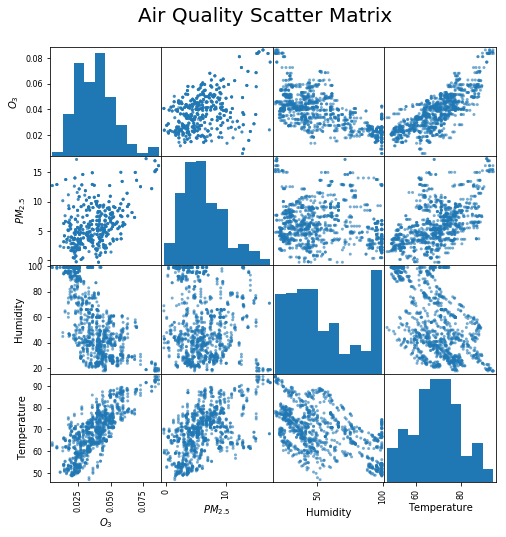

In [12]:
plt.rcParams['font.size'] = 10
#fig, ax = plt.subplots(figsize=[10,10])
mtx = scatter_matrix(opth, alpha=0.6, figsize=(8,8), diagonal='hist')
plt.suptitle("Air Quality Scatter Matrix", y=0.95, fontsize=20)
#plt.savefig("../farid_output/air_quality_scatter_matrix.pdf", dpi=300)
#plt.savefig("../farid_output/air_quality_scatter_matrix.png", dpi=300)

In [55]:
#normalize air quality arrays

o3 = stats.zscore(o3)
pm25 = stats.zscore(pm25)
temps = stats.zscore(temps)
humid = stats.zscore(humid)

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


In [56]:
# create air quality array

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


### Split data into train/test sets

In [57]:
Dtrain, Dtest, aqtrain, aqtest = train_test_split(D_vrat, aq_opth, test_size=0.2)

---

## CNN

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

In [59]:
def CNN_model(in_dim, out_dim, filtersize=50):
    Inputs = keras.Input(shape=(in_dim, 1), name="input_diffratio")
    
    Conv1D_1 = layers.Conv1D(16, kernel_size=(filtersize), padding="same", activation="relu")(Inputs)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(filtersize), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    
    Dropout = layers.Dropout(0.5)(MaxPool_2)
    Flatten = layers.Flatten()(Dropout)
    
    Dense = layers.Dense(512, activation="relu")(Flatten)
    Outputs = layers.Dense(out_dim)(Dense)
    
    model = keras.Model(inputs=[Inputs], outputs=[Outputs])
    
    return model

In [60]:
def plot_loss_history(model):
    f, ((ax1, ax2)) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'])
    ax2.plot(model.history['loss'])
    ax2.plot(model.history['val_loss'])
    ax2.set_title('CNN Model Log(loss)')
    ax2.set_ylabel('log(loss)')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=13, axis='x')
    ax2.legend(['train', 'test'])
    ax2.set_yscale('log')
    plt.show()

In [69]:
in_dim = D_vrat.shape[1]
out_dim = aq_opth.shape[1]
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")

In [70]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_diffratio (InputLayer) (None, 848, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 848, 16)           816       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 424, 16)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 424, 32)           25632     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 212, 32)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6784)              0         
__________

In [71]:
Dtrain_1 = Dtrain.reshape(Dtrain.shape[0], Dtrain.shape[1], 1)
Dtest_1 = Dtest.reshape(Dtest.shape[0], Dtest.shape[1], 1)

In [76]:
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")
CNNmodel = cnn.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=200, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/200
881/881 [==============================] - 2s 2ms/step - loss: 1.1842 - val_loss: 1.0151
Epoch 2/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9957 - val_loss: 1.0161
Epoch 3/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9949 - val_loss: 1.0130
Epoch 4/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9929 - val_loss: 1.0107
Epoch 5/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9942 - val_loss: 1.0126
Epoch 6/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9950 - val_loss: 1.0146
Epoch 7/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9939 - val_loss: 1.0105
Epoch 8/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9929 - val_loss: 1.0098
Epoch 9/200
881/881 [==============================] - 1s 2ms/step - loss: 0.9877 - val_loss: 1.0073
Epoch 10/200
881/881 [=======================

Epoch 81/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8289 - val_loss: 0.8875
Epoch 82/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8332 - val_loss: 0.9112
Epoch 83/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8402 - val_loss: 0.9260
Epoch 84/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8192 - val_loss: 0.8914
Epoch 85/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8216 - val_loss: 0.8871
Epoch 86/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8209 - val_loss: 0.9349
Epoch 87/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8581 - val_loss: 0.9222
Epoch 88/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8408 - val_loss: 0.9727
Epoch 89/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8922 - val_loss: 0.8940
Epoch 90/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8575

881/881 [==============================] - 1s 2ms/step - loss: 0.8182 - val_loss: 0.9053
Epoch 161/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8486 - val_loss: 0.8791
Epoch 162/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8410 - val_loss: 0.9023
Epoch 163/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8180 - val_loss: 0.8852
Epoch 164/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8192 - val_loss: 0.9006
Epoch 165/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8184 - val_loss: 0.8817
Epoch 166/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8165 - val_loss: 0.8785
Epoch 167/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8099 - val_loss: 0.8900
Epoch 168/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8040 - val_loss: 0.8949
Epoch 169/200
881/881 [==============================] - 1s 2ms/step - loss: 0.8146 - v

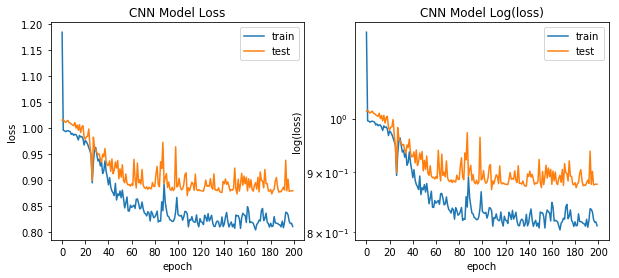

In [77]:
plot_loss_history(CNNmodel)

In [78]:
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")
CNNmodel = cnn.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=80, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/80
881/881 [==============================] - 2s 2ms/step - loss: 1.0684 - val_loss: 1.0159
Epoch 2/80
881/881 [==============================] - 1s 2ms/step - loss: 0.9605 - val_loss: 0.9367
Epoch 3/80
881/881 [==============================] - 1s 2ms/step - loss: 0.8876 - val_loss: 0.8416
Epoch 4/80
881/881 [==============================] - 1s 2ms/step - loss: 0.8094 - val_loss: 0.8038
Epoch 5/80
881/881 [==============================] - 1s 2ms/step - loss: 0.7916 - val_loss: 0.8658
Epoch 6/80
881/881 [==============================] - 1s 2ms/step - loss: 0.8564 - val_loss: 0.7911
Epoch 7/80
881/881 [==============================] - 1s 2ms/step - loss: 0.7892 - val_loss: 0.7883
Epoch 8/80
881/881 [==============================] - 1s 2ms/step - loss: 0.7768 - val_loss: 0.8001
Epoch 9/80
881/881 [==============================] - 1s 2ms/step - loss: 0.7583 - val_loss: 0.7531
Epoch 10/80
881/881 [==============================] -

In [79]:
# model MSE on training and testing sets

train_mse = cnn.evaluate(Dtrain_1, aqtrain)
test_mse = cnn.evaluate(Dtest_1, aqtest)

print(train_mse, test_mse)

221/221 [==============================] - 0s 580us/step
0.4626608879287451 0.495504603936122


### Predict Air Quality for training and Testing Sets

In [80]:
import time
start_time = time.time()

aqtrain_pred = cnn.predict(Dtrain_1)
aqtest_pred = cnn.predict(Dtest_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:00:00


In [81]:
print(aqtrain.shape)
print(aqtest.shape)

(881, 4)
(221, 4)


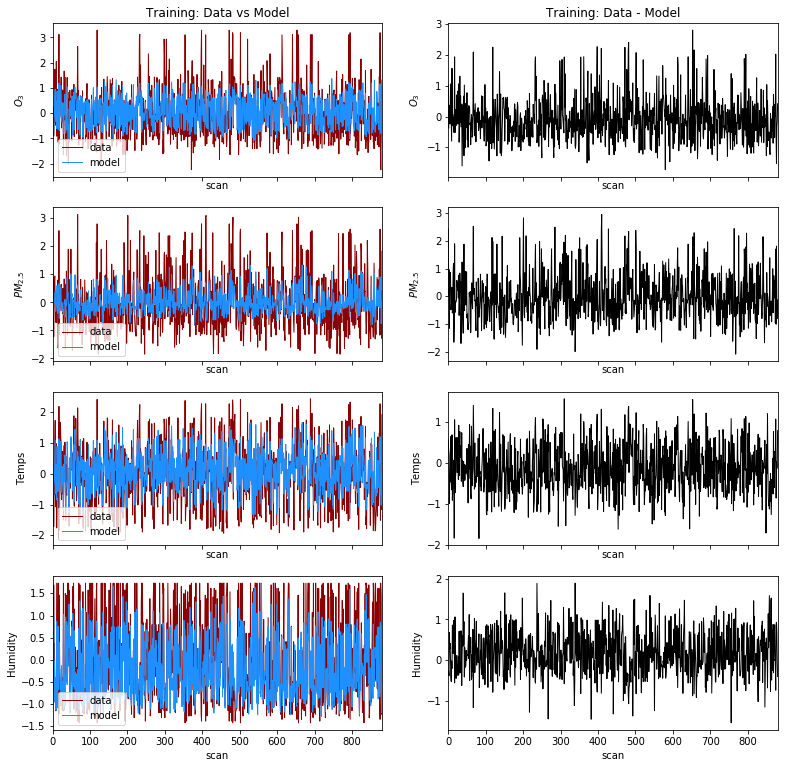

In [85]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Training: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtrain[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtrain.shape[0])

axes[0,1].set_title('Training: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtrain[:,i] - aqtrain_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtrain.shape[0])
    
plt.show()

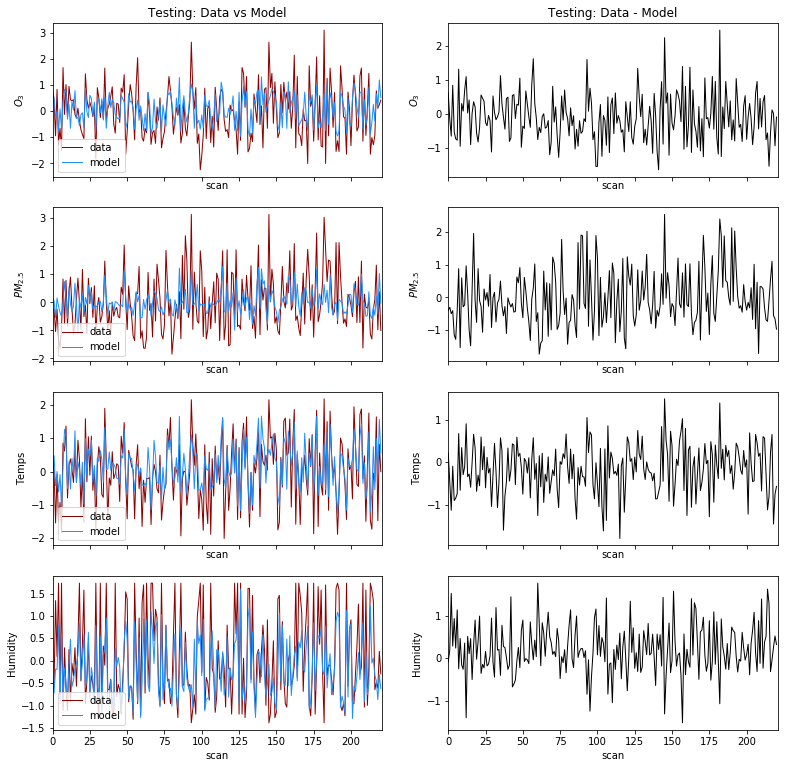

In [87]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Testing: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtest[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtest_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtest.shape[0])

axes[0,1].set_title('Testing: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtest[:,i] - aqtest_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtest.shape[0])
    
plt.show()